---
title: "Make predictions as lasso model of SPI tree depth"

author: "Benjamin Doran"

date: today

---

## Setup

In [248]:
using DrWatson
@quickactivate "Doran_etal_2022"

using SPI, MLJ
using MLJBase: train_test_pairs
using Clustering, Distances
using Muon, CSV, DataFrames
using StatsPlots, StatsBase
theme(:default, grid=false, label="")
using NewickTree, NewickTreeTools
using Gotree_jll
using Random: seed!

using Distances
using NearestNeighbors

getlims(x) = x |> extrema |> x->abs.(x) |> maximum |> x->(-x,x)

function getlims(x, y) 
    lims = extrema(vcat(x, y))
    lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
end

Base.@kwdef struct GroupedEuclidean{T} <: Metric
    groups::Vector{T}
end
function (dist::GroupedEuclidean)(r, a, b)
    for grp in dist.groups
        r += sqrt(sum(abs2.(a[grp] .- b[grp])))
    end
    r
end
function (dist::GroupedEuclidean)(a, b)
    r = zero(eltype(a))
    dist(r, a, b)
end
function (dist::GroupedEuclidean)(a::Number, b::Number)
    euclidean(a, b)
end
groupedeuclidean(a, b, intervals=collect(axes(a,1))) = GroupedEuclidean(intervals)(a, b)
groupedeuclidean!(r, a, b, intervals=collect(axes(a,1))) = GroupedEuclidean(intervals)(r, a, b)

get_predictions(ŷ, y) = ŷ
MLJ.reports_each_observation(::typeof(get_predictions)) = true;

In [58]:
# @load LogisticClassifier pkg=MLJLinearModels verbosity=0
@load LassoRegressor pkg=MLJLinearModels verbosity=0
@load MultinomialClassifier pkg=MLJLinearModels verbosity=0
@load OneHotEncoder pkg=MLJModels verbosity=0
# DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree

OneHotEncoder

In [59]:
ddir = datadir("exp_pro", "BB728")
rdir = projectdir("_research", "metabolite_SBA_Lasso_model_mark2") |> mkpath
pdir = plotsdir("metabolite_SBA_Lasso_model_mark2") |> mkpath
biobank = readh5mu(joinpath(ddir, "BB728.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon ~/.julia/packages/Muon/eLqpV/src/mudata.jl:351


MuData object 728 ✕ 21485
└ metabolites_foldchange
  AnnData object 728 ✕ 50
└ metabolites_millimolar
  AnnData object 728 ✕ 10
└ UPorder_oggs
  AnnData object 728 ✕ 10177
└ oggs
  AnnData object 728 ✕ 11248

In [60]:
trn_mask = biobank.obs.inBB673 .== 1
tst_mask = biobank.obs.inBB673 .== 0
trn_mtx = biobank["UPorder_oggs"].X[:,:][trn_mask, :]
tst_mtx = biobank["UPorder_oggs"].X[:,:][tst_mask, :];
mtx = biobank["UPorder_oggs"].X[:,:];

In [61]:
bbusv = SVD(
    biobank["UPorder_oggs"].obsm["inferredLSVs"][:,:],
    biobank["UPorder_oggs"].uns["UP_SVs"][:],
    biobank["UPorder_oggs"].varm["UP_RSVs"][:, :]',
    );
norm(mtx .- projectout(bbusv)) / norm(mtx)

0.03065109952898508

In [62]:
sigresdf = CSV.read(joinpath(ddir, "significant_metabolites_in_subsetSPItree_numisolatesperspecies=+20.csv"), DataFrame)

earlytreesigmetabolitesdf = filter(:node_depth_maxeffect => >(3.5), sigresdf) |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df, :effect_size_abs => maximum) |>
    df -> sort(df, :effect_size_abs_maximum, rev=true)
middletreesigmetabolitesdf = filter(:node_depth_maxeffect => (x)-> 2 .< x .< 3.5, sigresdf) |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df, :effect_size_abs => maximum) |>
    df -> sort(df, :effect_size_abs_maximum, rev=true)
latetreesigmetabolitesdf = filter(:node_depth_maxeffect => <(2), sigresdf) |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df, :effect_size_abs => maximum) |>
    df -> sort(df, :effect_size_abs_maximum, rev=true);

metabolite_has_effectsize_mask = vcat(
    earlytreesigmetabolitesdf,
    middletreesigmetabolitesdf,
    latetreesigmetabolitesdf,
).effect_size_abs_maximum .> 0.6;

orderedmetabolites_names = vcat(
    earlytreesigmetabolitesdf.metabolite_name,
    middletreesigmetabolitesdf.metabolite_name,
    latetreesigmetabolitesdf.metabolite_name,
);
metabolite_mask_ord_early = indexin(earlytreesigmetabolitesdf.metabolite_name, replace.(biobank["metabolites_foldchange"].var_names, "_rel"=>""));
metabolite_mask_ord_middle = indexin(middletreesigmetabolitesdf.metabolite_name, replace.(biobank["metabolites_foldchange"].var_names, "_rel"=>""));
metabolite_mask_ord_late = indexin(latetreesigmetabolitesdf.metabolite_name, replace.(biobank["metabolites_foldchange"].var_names, "_rel"=>""));
metabolite_mask_ord = indexin(orderedmetabolites_names, replace.(biobank["metabolites_foldchange"].var_names, "_rel"=>""));

In [63]:
bb_met_lfc = biobank["metabolites_foldchange"].X[:, :];
bb_met_lfc[isinf.(bb_met_lfc)] .= 0.0;
metabolicdistance = pairwise(Euclidean(), bb_met_lfc; dims=1);

In [64]:
metabolicallyvariabledf = biobank.obs[trn_mask, :] |>
    df->DataFrames.transform(df, eachindex => :rowid) |>
    df->groupby(df, :species) |>
    df->combine(df, 
        nrow => :num_isolates, 
        :rowid => ((x)->maximum(metabolicdistance[x,x])) => :max_metabolicdistance,
        :rowid => ((x)->maximum(metabolicdistance[x,x]) > 20) => :isvariable,
        ) |>
    df->filter(:num_isolates => >=(10), df) |>
    df->sort(df, [:max_metabolicdistance, :num_isolates], rev=true)

specieswith20reps = metabolicallyvariabledf |>
    df -> filter(:num_isolates => >=(20), df) |>
    df -> filter(:species => !=("unclassified"), df) |>
    df -> sort(df, :num_isolates, rev=true)


spe20rep_mask = .!isnothing.(indexin(biobank.obs.species[trn_mask], specieswith20reps.species));

In [65]:
full_train_mask = zeros(Bool, 728)
full_train_mask[trn_mask] .= spe20rep_mask;

full_test_mask = ones(Bool, 728)
full_test_mask[trn_mask] = .!spe20rep_mask
sum(full_train_mask), sum(full_test_mask)

(356, 372)

In [66]:
bbmtx = biobank["oggs"].X[:, :]
bbmtx_trn = bbmtx[full_train_mask, :]
bbmtx_tst = bbmtx[full_test_mask, :]
# filter out oggs that are constant
ogg_mask = vec(mapslices(c->std(c) > 0, bbmtx_trn, dims=1))
bbmtx_trn = bbmtx_trn[:, ogg_mask]
bbmtx_tst = bbmtx_tst[:, ogg_mask]
zbbmtx_trn = mapslices(StatsBase.zscore, bbmtx_trn, dims=1)
zbbmtx_tst = mapslices(StatsBase.zscore, bbmtx_tst, dims=1)
replace!(zbbmtx_tst, NaN=>0.) # replace zscored NaNs with zeros (it's what they were before)
bbusv_internal = svd(zbbmtx_trn)
BBUinternal_tst = projectinLSV(zbbmtx_tst, bbusv_internal)
BBpcs_trn = bbusv_internal.U * diagm(bbusv_internal.S)
BBpcs_tst = BBUinternal_tst * diagm(bbusv_internal.S);

In [67]:
size(zbbmtx_trn)

(356, 5449)

In [68]:
biobank.obs[!, "species_donor"] = biobank.obs.species .* "_" .* biobank.obs.donor
bbobs_trn = biobank.obs[full_train_mask, :]
bbobs_tst = biobank.obs[full_test_mask, :];

In [233]:
subsetDij = biobank["UPorder_oggs"].obsp["SDij"][full_train_mask, full_train_mask];
subsettree_hc = hclust(subsetDij, linkage=:average, branchorder=:optimal)
subsettreestring = SPI.nwstr(subsettree_hc, bbobs_trn.ID; labelinternalnodes=false)
subsettree = readnw(subsettreestring);

In [70]:
trnX = mtx[full_train_mask, :]
trnYdf = bbobs_trn;

metab_trnY = bb_met_lfc[full_train_mask, metabolite_mask_ord];
metab_tstY = bb_met_lfc[full_test_mask, metabolite_mask_ord];

measurable_metabolites_mask = mapslices(c->mean(c .==0.) < .9, metab_trnY, dims=1)|>vec;
keepmetabolites_mask = measurable_metabolites_mask .& metabolite_has_effectsize_mask

PCs_trnX = DataFrame(BBpcs_trn[:, 1:10], :auto);
PCs_tstX = DataFrame(BBpcs_tst[:, 1:10], :auto);

In [71]:
# Find metabolites with improvement in full spectral model over top 3 model
lasso_oof_preds_df = CSV.read(projectdir("_research/metabolite_lasso_model/oof_lasso_preds_lambda=0.01.csv"), DataFrame);
# nrmse(y, ŷ) = rmse(y, ŷ) / mean(y)
mnames = orderedmetabolites_names[keepmetabolites_mask]
function get_scores(fun, df, predname, groupcol=:fold) 
    combine(groupby(df, groupcol)) do gdf 
        ŷs = gdf[:, Cols(mnames .* "_pred_".* predname)]
        ys = gdf[:, Cols(mnames .* "_true")]
        scores = map(zip(eachcol(ŷs), eachcol(ys))) do (ŷ, y)
            fun(ŷ, y)
        end |> permutedims
        scores
    end |>
    Matrix |>
    x->getindex(x, :, axes(x,2)[2:end]) |>
    permutedims
end

func = rsquared

all_scores_perfold = map(["full", "top3"]) do type
    scores = get_scores(func, lasso_oof_preds_df, type, "fold")
    mean(scores, dims=2), std(scores, dims=2)
end
scores_means = hcat(first.(all_scores_perfold)...)
scores_stds = hcat(last.(all_scores_perfold)...);

all_scores_perfold = map(["full", "top3"]) do type
    scores = get_scores(func, lasso_oof_preds_df, type, "fold")
end

allscores_perfold = permutedims(stack(all_scores_perfold), [3,1,2]);

using HypothesisTests
using MultipleTesting: adjust, Bonferroni, BenjaminiHochberg

poweroftest = mapslices(allscores_perfold, dims=(1,3)) do m
        pvalue(UnequalVarianceTTest(m[1, :], m[2, :]))
    end |> 
    x->dropdims(x, dims=(1,3)) |>
    p->adjust(p, BenjaminiHochberg()) |> 
    p->filter(<(0.05), p) |>
    p->floor.(Int, log10.(1 ./ p))

bothmodelswork = (scores_means[:, end] .> 0.5) .| (scores_means[:, begin] .> 0.5) |> findall
issig = mapslices(allscores_perfold, dims=(1,3)) do m
        pvalue(UnequalVarianceTTest(m[1, :], m[2, :]))
    end |> 
    x->dropdims(x, dims=(1,3)) |>
    p->adjust(p, BenjaminiHochberg()) |>
    # p->adjust(p, Bonferroni()) |>
    p -> (p .< 0.05) |>
    findall
rsq_test_mask = unique(vcat(issig, bothmodelswork));

improvedmetabolite_mask = rsq_test_mask
improvedmetabolite_names = orderedmetabolites_names[keepmetabolites_mask][rsq_test_mask]

13-element Vector{String31}:
 "Propionate"
 "Succinate"
 "Tryptamine"
 "Glycine"
 "Butyrate"
 "Acetate"
 "Valerate"
 "Cysteine"
 "Tryptophan"
 "5-Aminovalerate"
 "Phenylacetate"
 "2-Methylbutyrate"
 "Isovaleric-Acid"

In [72]:
orderedmetabolites_names[keepmetabolites_mask][issig]

10-element Vector{String31}:
 "Propionate"
 "Succinate"
 "Tryptamine"
 "Glycine"
 "Butyrate"
 "Acetate"
 "Valerate"
 "Cysteine"
 "Tryptophan"
 "5-Aminovalerate"

In [73]:
powerofalltests_fullvstop3 = mapslices(allscores_perfold, dims=(1,3)) do m
        pvalue(UnequalVarianceTTest(m[1, :], m[2, :]))
    end |> 
    x->dropdims(x, dims=(1,3)) |>
    p->adjust(p, BenjaminiHochberg()) |> 
    # p->filter(<(0.05), p) |>
    p->floor.(Int, log10.(1 ./ p));

In [74]:
specieslabels = [
    "Bacteroides uniformis",
    "Phocaeicola vulgatus",
    "Bacteroides thetaiotaomicron",
    "[Ruminococcus] gnavus",
    "Bifidobacterium breve",
    "[Eubacterium] rectale",
    "Dorea formicigenerans",
    "Coprococcus comes",
    "Blautia luti & Blautia wexlerae",
    "Anaerostipes hadrus",
]
shapes = permutedims([:circle, :rect, :star5, :diamond, :hexagon, :ltriangle, :pentagon, :utriangle, :dtriangle, :rtriangle, :star4])
speciescolors = wload(joinpath(ddir, "subsettreecolors.jld2"))["colors"]
speciescolors_ordered = permutedims(speciescolors[replace(indexin(sort(unique(trnYdf.species)), specieslabels), nothing=>9)])

In [75]:
using Random: seed!
seed!(424242)
cv = StratifiedCV(nfolds=5, shuffle=true);
folds = train_test_pairs(cv, 1:sum(full_train_mask), trnYdf.species);

## Ancestral encoding cross-fold validation

### Make SPI-LASSO predictions

In [76]:
UPfullPCs = bbusv.U[full_train_mask, :] * diagm(bbusv.S[:]);
partitions = getintervals(bbusv.S);

In [77]:
rdir

"/Users/ben/projects/Doran_etal_2022/_research/metabolite_SBA_Lasso_model_mark2"

In [78]:
K = 1 # Make predictions with SPI-LASSO
λ = 1e-3
REPS = 5
NFOLDS = 4

seed!(424242)
cv = StratifiedCV(nfolds=NFOLDS, shuffle=true);
folds = vcat([train_test_pairs(cv, 1:sum(full_train_mask), trnYdf.species) for i in 1:REPS]...)


mdl = MLJLinearModels.LassoRegressor(lambda=λ)


oof_preds_df_stacked = DataFrame()
inf_preds_df_stacked = DataFrame()
coefdf = DataFrame()
for (i, (fold_trn, fold_tst)) in collect(enumerate(folds))
# (i, (fold_trn, fold_tst)) = (1, folds[1])
# (i, (fold_trn, fold_tst)) = (2, folds[2])

    # Use tree to get lineage traces for each training and test sample
    foldPCs = UPfullPCs[fold_trn,:]
    trn_nns = map(r->partialsortperm(r, 1:K), eachrow(subsetDij[fold_trn, fold_trn]))
    tst_nns = map(r->partialsortperm(r, 1:K), eachrow(subsetDij[fold_tst, fold_trn]))

    foldhc = hclust(subsetDij[fold_trn, fold_trn], linkage=:average, branchorder=:optimal)
    foldtree = readnw(SPI.nwstr(foldhc, trnYdf.ID[fold_trn], labelinternalnodes=false))
    # ladderize!(foldtree, rev=false)
    
    # Make SBA ancester encoding
    trnXdf_all = map(prewalk(foldtree)) do node
        tmp = zeros(length(fold_trn))
        tmp[indexin(getleafnames(node), trnYdf.ID[fold_trn])] .= 1
        "node__$(id(node))" => tmp
    end |> DataFrame;
    isinternal_fold = map(!isleaf, prewalk(foldtree));
    treedists = mapinternalnodes(foldtree) do node
        network_distance(foldtree, node)
    end
    trnXdf = trnXdf_all[:, isinternal_fold];
    trnXdf = trnXdf[:, sortperm(treedists)];
    rename!(trnXdf, ["node__$i" for i in 1:size(trnXdf, 2)])
    
    # Get features for each out-of-fold isolate
    tstXdf = map(tst_nns) do nn
        trnXdf[nn, :] |>
        df -> combine(df, [c => mean for c in 1:size(df, 2)])
    end |> x->vcat(x...)
    # rename!(tstXdf, ["node__$i" for i in 1:size(tstXdf,2)])

    # fit lasso model
    individual_metabolite_results = []
    # (target_idx, target) = findfirst(==("Phenylacetate"), orderedmetabolites_names),"Phenylacetate"
    for (target_idx, target) in enumerate(orderedmetabolites_names)
        mach = machine(mdl, trnXdf, metab_trnY[fold_trn, target_idx])
        Base.with_logger(Base.NullLogger()) do
            fit!(mach, verbosity=0)
        end
        
        # save results of trained model
        inf_preds_df_stacked = vcat(inf_preds_df_stacked, DataFrame(
            :row_id => fold_trn,
            :metabolite_name => target,
            :fold => ((i-1)%NFOLDS)+1,
            :resample => ((i-1)÷NFOLDS)+1,
            :truth => metab_trnY[fold_trn, target_idx],
            :preds => MLJ.predict(mach, trnXdf),
        ))

        oof_preds_df_stacked = vcat(oof_preds_df_stacked, DataFrame(
            :row_id => fold_tst,
            :metabolite_name => target,
            :fold => ((i-1)%NFOLDS)+1 ,
            :resample => ((i-1)÷NFOLDS)+1 ,
            :truth => metab_trnY[fold_tst, target_idx],
            :preds => MLJ.predict(mach, tstXdf),
        ))

        coefdf = vcat(coefdf, stack(DataFrame(fitted_params(mach).coefs)) |>
            df -> begin df[!, :treedist] .= sort(treedists); df end |>
            df-> DataFrames.select(df,
                :value => ByRow(x->target) => :metabolite_name,
                :value => ByRow(x->i) => :fold,
                :variable => (x->split.(x, "__")) => [:treedepth, :class],
                :variable => :node_id,
                :value => :coef,
                :treedist,

            )
        )
    end;
    println("on $(i)th resample")
end

oof_preds_df = leftjoin(
    unstack(oof_preds_df_stacked, [:row_id, :fold, :resample], :metabolite_name, :truth; renamecols=(s)-> s*"_true"),
    unstack(oof_preds_df_stacked, [:row_id, :fold, :resample], :metabolite_name, :preds; renamecols=(s)-> s*"_pred_sbalasso"),
    on=[:row_id, :fold, :resample],
)
CSV.write(joinpath(rdir, "oof_predictions_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), oof_preds_df)
inf_preds_df = leftjoin(
    unstack(inf_preds_df_stacked, [:row_id, :fold, :resample], :metabolite_name, :truth; renamecols=(s)-> s*"_true"),
    unstack(inf_preds_df_stacked, [:row_id, :fold, :resample], :metabolite_name, :preds; renamecols=(s)-> s*"_pred_sbalasso"),
    on=[:row_id, :fold, :resample],
)
CSV.write(joinpath(rdir, "infold_predictions_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), inf_preds_df)

CSV.write(joinpath(rdir, "oof_predictions_stacked_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), oof_preds_df_stacked)
CSV.write(joinpath(rdir, "infold_predictions_stacked_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), inf_preds_df_stacked)

CSV.write(joinpath(rdir, "coefs_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), coefdf)

on 1th resample
on 2th resample
on 3th resample
on 4th resample
on 5th resample
on 6th resample
on 7th resample
on 8th resample
on 9th resample
on 10th resample
on 11th resample
on 12th resample
on 13th resample
on 14th resample
on 15th resample
on 16th resample
on 17th resample
on 18th resample
on 19th resample
on 20th resample


"/Users/ben/projects/Doran_etal_2022/_research/metabolite_SBA_Lasso_model_mark2/coefs_SPItreeLASSO_ancestralencoding_lambda=0.001.csv"

In [79]:
# speciescolorsontree = map(prewalk(foldtree)) do node
#     speciescolors_ordered[findfirst(==(mode(trnYdf.species[fold_trn][indexin(getleafnames(node), trnYdf.ID[fold_trn])])), sort(unique(trnYdf.species)))]
# end |> x-> x[2:end] |> permutedims
# plot(foldtree, 
#     title="CSB_stvar|uniprot fold tree (n=267)", 
#     fs=1, 
#     seriescolor=speciescolorsontree, 
#     # linewidth=foldtreewidths,
#     size=(400,600))

In [80]:
# foldtreewidths = map(prewalk(foldtree)) do node
#     !isleaf(node) && 
#         abs.(coefdf.coef[findfirst(==(string(id(node))), coefdf.class)])
# end |> x->x[2:end] |> permutedims

In [81]:
# speciescolorsontree = map(prewalk(foldtree)) do node
#     speciescolors_ordered[findfirst(==(mode(trnYdf.species[fold_trn][indexin(getleafnames(node), trnYdf.ID[fold_trn])])), sort(unique(trnYdf.species)))]
# end |> x-> x[2:end] |> permutedims
# plot(foldtree, 
#     title="CSB_stvar|uniprot fold tree (n=267)", 
#     fs=1, 
#     seriescolor=speciescolorsontree, 
#     linewidth=foldtreewidths,
#     size=(400,600))

In [82]:
# speciescolorsontree = map(prewalk(subsettree)) do node
#     speciescolors_ordered[findfirst(==(mode(trnYdf.species[indexin(getleafnames(node), trnYdf.ID)])), sort(unique(trnYdf.species)))]
# end |> x-> x[2:end] |> permutedims
# plot(subsettree, title="CSB_stvar|uniprot tree", fs=1, seriescolor=speciescolorsontree, size=(400,600))

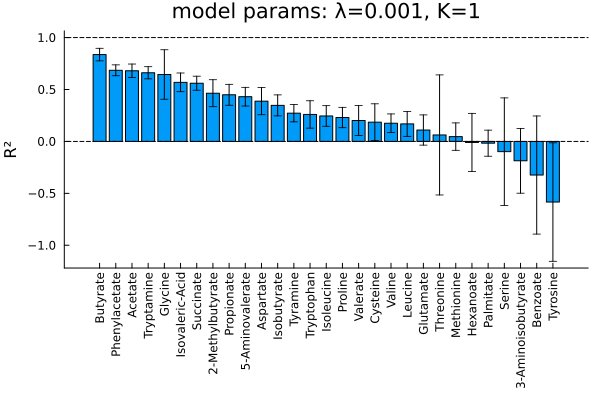

In [83]:
measure_pltdf = groupby(oof_preds_df_stacked, [:metabolite_name, :fold, :resample]) |>
    df -> combine(df, 
        [:preds, :truth] => ((yhat, y) -> rsquared(yhat, y)) => :rsquared,
    ) |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df,
        :rsquared => mean,
        :rsquared => std,
    ) |>
    df -> df[keepmetabolites_mask, :] |>
    df -> sort(df, :rsquared_mean, rev=true);

@df measure_pltdf bar(
    :metabolite_name, :rsquared_mean, yerror=:rsquared_std,
    xticks=((1:length(unique(:metabolite_name))).-.5, :metabolite_name),
    xrotation=90,
    label="",
    grid=false,
    bottommargin=10Plots.Measures.mm,
    title="model params: λ=$λ, K=$K",
    ylabel="R²",
)
hline!([0, 1], c=:black, label="", linestyle=:dash)

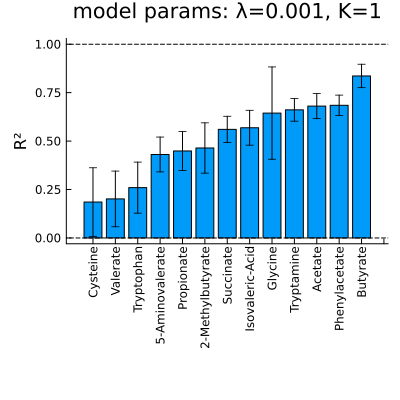

In [84]:
measure_pltdf = groupby(oof_preds_df_stacked, [:metabolite_name, :fold, :resample]) |>
    df -> combine(df, 
        [:preds, :truth] => ((yhat, y) -> rsquared(yhat, y)) => :rsquared,
    ) |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df,
        :rsquared => mean,
        :rsquared => std,
    ) |>
    df -> df[keepmetabolites_mask, :] |>
    df -> df[improvedmetabolite_mask, :] |>
    df -> sort(df, :rsquared_mean, rev=false);

@df measure_pltdf bar(
    :metabolite_name, :rsquared_mean, yerror=:rsquared_std,
    xticks=((1:sum(keepmetabolites_mask)).-.5, :metabolite_name),
    xrotation=90,
    label="",
    grid=false,
    bottommargin=10Plots.Measures.mm,
    title="model params: λ=$λ, K=$K",
    ylabel="R²",
    size=(400,400),
)
hline!([0, 1], c=:black, label="", linestyle=:dash)

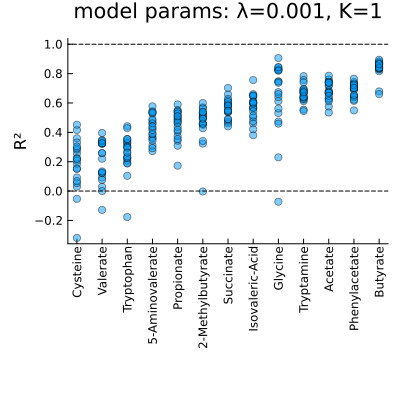

In [85]:
measure_pltdf = groupby(oof_preds_df_stacked, [:metabolite_name, :fold, :resample]) |>
    df -> combine(df, 
        [:preds, :truth] => ((yhat, y) -> rsquared(yhat, y)) => :rsquared,
    ) |>
    df -> groupby(df, :metabolite_name) |>
    df -> DataFrames.transform(df,
        :rsquared => mean,
    ) |>
    df -> subset(df, :metabolite_name => (x -> x .∈ Ref(improvedmetabolite_names)) ) |>
    df -> sort(df, :rsquared_mean)

@df measure_pltdf dotplot(string.(round.(:rsquared_mean, digits=5)), :rsquared, #yerror=:rsquared_std,
    xrotation=90,
    label="",
    grid=false,
    bottommargin=10Plots.Measures.mm,
    alpha=.5,
    mode=:none,
    xticks=((1:length(unique(:metabolite_name))) .- 0.5, unique(:metabolite_name)),
    title="model params: λ=$λ, K=$K",
    ylabel="R²",
    size=(400,400),    
)
hline!([0, 1], c=:black, label="", linestyle=:dash)

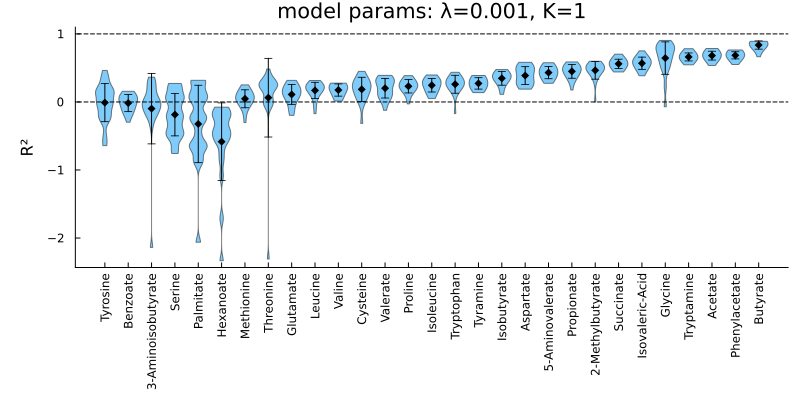

In [86]:
measure_pltdf = oof_preds_df_stacked |>
    df -> subset(df, :metabolite_name => (x -> x .∈ Ref(orderedmetabolites_names[keepmetabolites_mask])) ) |>
    df -> groupby(df, [:metabolite_name, :fold, :resample]) |>
    df -> combine(df, 
        [:preds, :truth] => ((yhat, y) -> rsquared(yhat, y)) => :rsquared,
    ) |>
    df -> groupby(df, :metabolite_name) |>
    df -> DataFrames.transform(df,
        # :rsquared => (x->mean(filter(isfinite, x))) => :rsquared_mean,
        :rsquared => mean => :rsquared_mean,
    ) |>
    df -> sort(df, :rsquared_mean)

@df measure_pltdf violin(string.(round.(:rsquared_mean, digits=5)), :rsquared, #yerror=:rsquared_std,
    xrotation=90,
    label="",
    grid=false,
    bottommargin=15Plots.Measures.mm,
    leftmargin=7Plots.Measures.mm,
    alpha=.5,
    mode=:none,
    xticks=((1:length(unique(:metabolite_name))) .- 0.5, unique(:metabolite_name)),
    title="model params: λ=$λ, K=$K",
    ylabel="R²",
    size=(800,400),    
)

groupby(measure_pltdf, :metabolite_name) |>
    df->combine(df,
        :rsquared => mean,
        :rsquared => std) |>
    df -> @df df scatter!(
        string.(round.(:rsquared_mean, digits=5)), 
        :rsquared_mean, 
        yerror=:rsquared_std,
        markershape=:diamond,
        c=:black,
        label="",
        )

hline!([0, 1], c=:black, label="", linestyle=:dash)

In [87]:
savefig(joinpath(pdir, "rsquared_violin_of_allmetabolites_with10pctmeasurments.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model_mark2/rsquared_violin_of_allmetabolites_with10pctmeasurments.pdf"

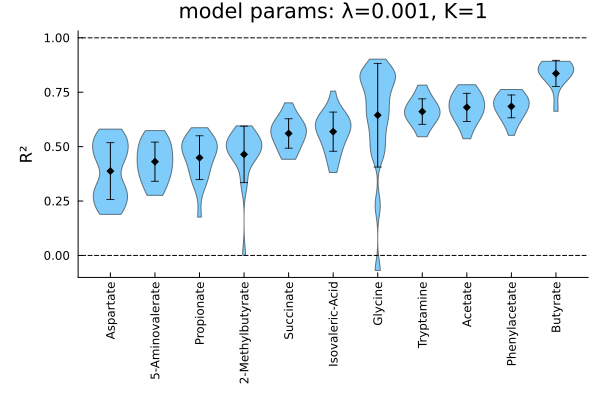

In [88]:
measure_pltdf = oof_preds_df_stacked |>
    df -> subset(df, :metabolite_name => (x -> x .∈ Ref(orderedmetabolites_names[keepmetabolites_mask])) ) |>
    df -> groupby(df, [:metabolite_name, :fold, :resample]) |>
    df -> combine(df, 
        [:preds, :truth] => ((yhat, y) -> rsquared(yhat, y)) => :rsquared,
    ) |>
    df -> groupby(df, :metabolite_name) |>
    df -> DataFrames.transform(df,
        # :rsquared => (x->mean(filter(isfinite, x))) => :rsquared_mean,
        :rsquared => mean => :rsquared_mean,
        :rsquared => maximum => :rsquared_max,
    ) |>
    df -> subset(df, 
        :rsquared_max => (x -> x .> .5),
    ) |>
    df -> sort(df, :rsquared_mean)

@df measure_pltdf violin(string.(round.(:rsquared_mean, digits=3)), :rsquared, #yerror=:rsquared_std,
    xrotation=90,
    label="",
    grid=false,
    bottommargin=10Plots.Measures.mm,
    leftmargin=5Plots.Measures.mm,
    alpha=.5,
    mode=:none,
    xticks=((1:length(unique(:metabolite_name))) .- 0.5, unique(:metabolite_name)),
    title="model params: λ=$λ, K=$K",
    ylabel="R²",
    size=(600,400),    
)

groupby(measure_pltdf, :metabolite_name) |>
    df->combine(df,
        :rsquared => mean,
        :rsquared => std) |>
    df -> @df df scatter!(
        string.(round.(:rsquared_mean, digits=3)), 
        :rsquared_mean, 
        yerror=:rsquared_std,
        markershape=:diamond,
        c=:black,
        label="",
        )

hline!([0, 1], c=:black, label="", linestyle=:dash)

In [89]:
savefig(joinpath(pdir, "rsquared_violin_of_allmetabolites_with1foldgreaterthan1half.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model_mark2/rsquared_violin_of_allmetabolites_with1foldgreaterthan1half.pdf"

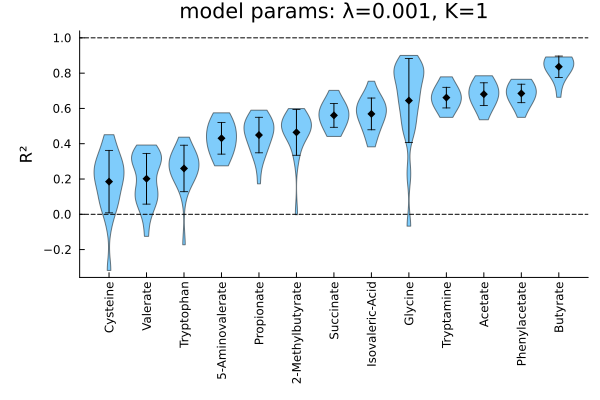

In [90]:
measure_pltdf = oof_preds_df_stacked |>
    df -> subset(df, :metabolite_name => (x -> x .∈ Ref(improvedmetabolite_names)) ) |>
    df -> groupby(df, [:metabolite_name, :fold, :resample]) |>
    df -> combine(df, 
        [:preds, :truth] => ((yhat, y) -> rsquared(yhat, y)) => :rsquared,
    ) |>
    df -> groupby(df, :metabolite_name) |>
    df -> DataFrames.transform(df,
        # :rsquared => (x->mean(filter(isfinite, x))) => :rsquared_mean,
        :rsquared => mean => :rsquared_mean,
        :rsquared => maximum => :rsquared_max,
    ) |>
    df -> sort(df, :rsquared_mean)

@df measure_pltdf violin(string.(round.(:rsquared_mean, digits=5)), :rsquared, #yerror=:rsquared_std,
    xrotation=90,
    label="",
    grid=false,
    bottommargin=10Plots.Measures.mm,
    leftmargin=5Plots.Measures.mm,
    alpha=.5,
    mode=:none,
    xticks=((1:length(unique(:metabolite_name))) .- 0.5, unique(:metabolite_name)),
    title="model params: λ=$λ, K=$K",
    ylabel="R²",
    size=(600,400),    
)

groupby(measure_pltdf, :metabolite_name) |>
    df->combine(df,
        :rsquared => mean,
        :rsquared => std) |>
    df -> @df df scatter!(
        string.(round.(:rsquared_mean, digits=5)), 
        :rsquared_mean, 
        yerror=:rsquared_std,
        markershape=:diamond,
        c=:black,
        label="",
        )

hline!([0, 1], c=:black, label="", linestyle=:dash)

In [91]:
savefig(joinpath(pdir, "rsquared_violin_of_improvedmetabolites.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model_mark2/rsquared_violin_of_improvedmetabolites.pdf"

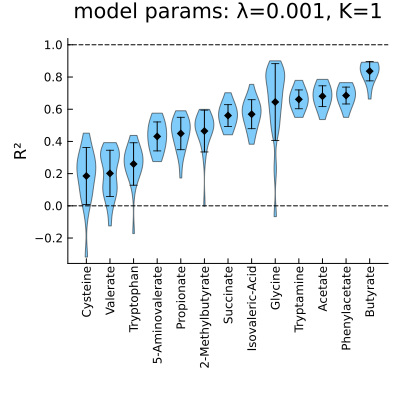

In [92]:
measure_pltdf = groupby(oof_preds_df_stacked, [:metabolite_name, :fold, :resample]) |>
    df -> combine(df, 
        [:preds, :truth] => ((yhat, y) -> rsquared(yhat, y)) => :rsquared,
    ) |>
    df -> groupby(df, :metabolite_name) |>
    df -> DataFrames.transform(df,
        :rsquared => mean,
    ) |>
    df -> subset(df, :metabolite_name => (x -> x .∈ Ref(improvedmetabolite_names)) ) |>
    df -> sort(df, :rsquared_mean)

@df measure_pltdf violin(string.(round.(:rsquared_mean, digits=5)), :rsquared, #yerror=:rsquared_std,
    xrotation=90,
    label="",
    grid=false,
    bottommargin=5Plots.Measures.mm,
    alpha=.5,
    mode=:none,
    xticks=((1:length(unique(:metabolite_name))) .- 0.5, unique(:metabolite_name)),
    title="model params: λ=$λ, K=$K",
    ylabel="R²",
    size=(400,400),    
)

groupby(measure_pltdf, :metabolite_name) |>
    df->combine(df,
        :rsquared => mean,
        :rsquared => std) |>
    df -> @df df scatter!(
        string.(round.(:rsquared_mean, digits=5)), 
        :rsquared_mean, 
        yerror=:rsquared_std,
        markershape=:diamond,
        c=:black,
        label="",
        )

hline!([0, 1], c=:black, label="", linestyle=:dash)

In [93]:
savefig(joinpath(pdir, "rsquared_violin_of_improvedmetabolites_smallsize.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model_mark2/rsquared_violin_of_improvedmetabolites_smallsize.pdf"

In [94]:
coefdf_avgbytreedist = groupby(coefdf, [:metabolite_name, :treedist]) |>
    df -> combine(df, 
        :coef => (x-> mean(x) - 1std(x)) => :coef_lowerbound,
        :coef => (x-> mean(x) + 1std(x)) => :coef_upperbound,
        :coef => (x-> mean(x)) => :coef_mean,
        :coef => (x-> mean(abs.(x))) => :coef_meanabs,
        :coef => (x-> median(x)) => :coef_median,
        :coef => (x-> quantile(x, 0.25)) => :coef_Q2,
        :coef => (x-> quantile(x, 0.75)) => :coef_Q3,
        nrow
    ) |>
    df -> DataFrames.transform(df,
        [:coef_lowerbound, :coef_upperbound] => ((lo, hi) -> lo .> 0 .|| hi .< 0) => :isnonzero,
    );

In [95]:
predictable_metabolite_idx = indexin(improvedmetabolite_names, orderedmetabolites_names);

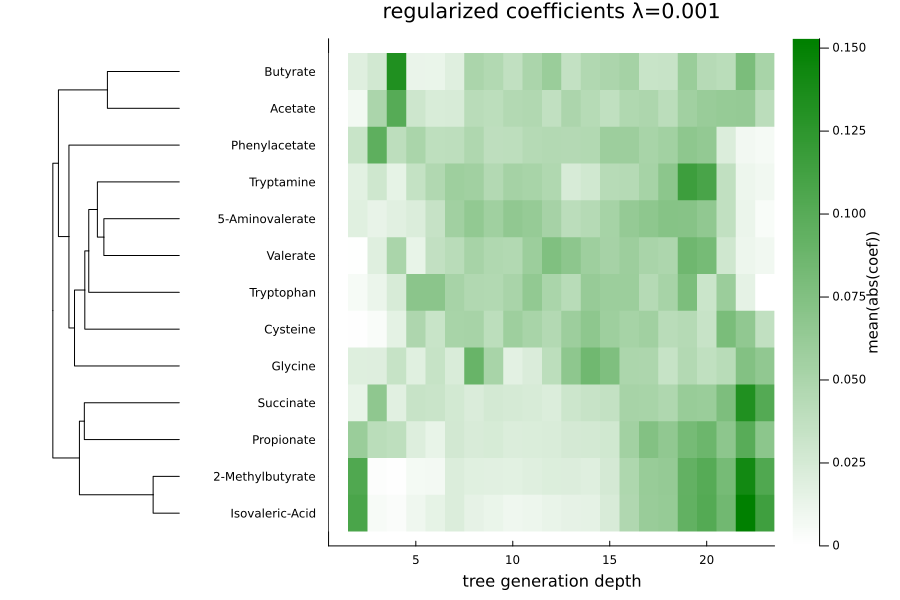

In [96]:
coef_mtxdf = unstack(coefdf_avgbytreedist, :metabolite_name, :treedist, :coef_meanabs) |>
    df -> df[indexin(orderedmetabolites_names, df.metabolite_name), :] |>
    df -> df[reverse(predictable_metabolite_idx), :] #|> 
coefmtx = Matrix(coef_mtxdf[:, 2:end])
coefmtx = coefmtx ./ sum(coefmtx, dims=2)
pltmtx = coefmtx

rowhc = hclust(pairwise(Euclidean(), coefmtx, dims=1), branchorder=:optimal);
roworder = rowhc.order #sortperm(vec(sum(abs.(coefmtx), dims=2)), rev=true)
# pltmtx = abs.(coefmtx)
# rownames = coef_mtxdf.metabolite_name
pltmtx = abs.(pltmtx[roworder, :])
rownames = coef_mtxdf.metabolite_name[roworder]

tplot = plot(
    # readnw(SPI.nwstr(rowhc, String.(coef_mtxdf.metabolite_name), labelinternalnodes=false)), 
    readnw(SPI.nwstr(rowhc, repeat([""], length(rowhc.order)), labelinternalnodes=false)), 
    fs=1
)

hplot = heatmap(pltmtx,
    title="regularized coefficients λ=$λ",
    yticks=(1:size(coefmtx, 1), rownames),
    # xticks=(2:2:10, (2:2:10) .* 10),
    # clims = extrema(coefmtx) |> x->abs.(x) |> maximum |> x->(-x, x),
    colorbartitle="mean(abs(coef))",
    xlabel="tree generation depth",
    c=[:white, :green],
    size=(900, 600),
    margin=3Plots.Measures.mm,
)

layout = @layout [a{.2w} b]
plot(tplot, hplot, link=:y, layout=layout)

In [97]:
savefig(joinpath(pdir, "Coeff_heatmap_clusteredimprovedmetabolites.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model_mark2/Coeff_heatmap_clusteredimprovedmetabolites.pdf"

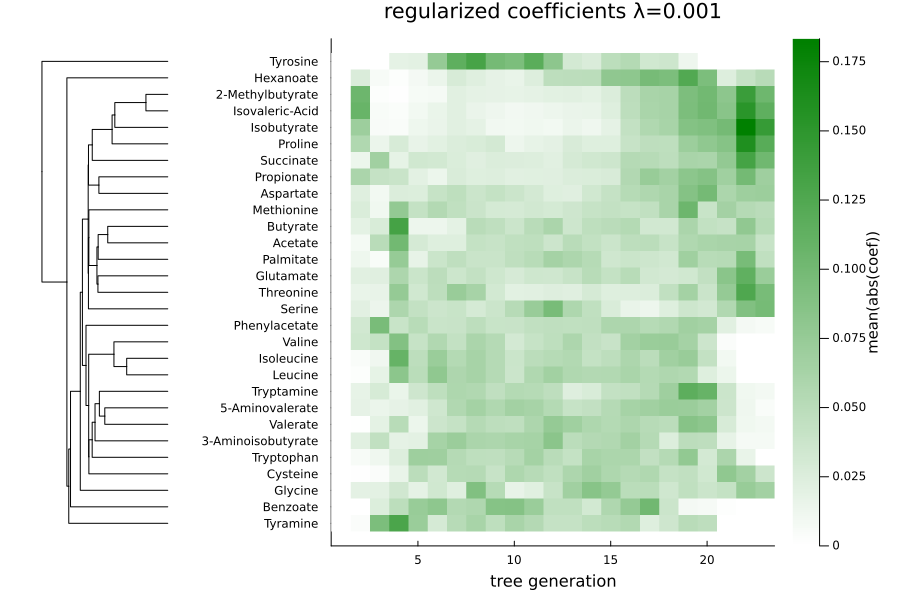

In [114]:
coef_mtxdf = unstack(coefdf_avgbytreedist, :metabolite_name, :treedist, :coef_meanabs) |>
    df -> df[indexin(orderedmetabolites_names, df.metabolite_name), :] |>
    df -> df[keepmetabolites_mask, :] #|> 
coefmtx = Matrix(coef_mtxdf[:, 2:end])
coefmtx = coefmtx ./ sum(coefmtx, dims=2)
pltmtx = coefmtx

rowhc = hclust(pairwise(Euclidean(), coefmtx, dims=1), branchorder=:optimal);
roworder = rowhc.order #sortperm(vec(sum(abs.(coefmtx), dims=2)), rev=true)
# pltmtx = abs.(coefmtx)
# rownames = coef_mtxdf.metabolite_name
pltmtx = abs.(pltmtx[roworder, :])
rownames = coef_mtxdf.metabolite_name[roworder]

tplot = plot(
    # readnw(SPI.nwstr(rowhc, String.(coef_mtxdf.metabolite_name), labelinternalnodes=false)), 
    readnw(SPI.nwstr(rowhc, repeat([""], length(rowhc.order)), labelinternalnodes=false)), 
    fs=1
)

hplot = heatmap(pltmtx,
    title="regularized coefficients λ=$λ",
    yticks=(1:size(coefmtx, 1), rownames),
    # xticks=(2:2:10, (2:2:10) .* 10),
    # clims = extrema(coefmtx) |> x->abs.(x) |> maximum |> x->(-x, x),
    colorbartitle="mean(abs(coef))",
    xlabel="tree generation",
    c=[:white, :green],
    size=(900, 600),
    margin=3Plots.Measures.mm,
)

layout = @layout [a{.2w} b]
plot(tplot, hplot, link=:y, layout=layout)

In [115]:
savefig(joinpath(pdir, "Coeff_heatmap_clusteredmetabolites_greaterthan10pctmeasurements.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model_mark2/Coeff_heatmap_clusteredmetabolites_greaterthan10pctmeasurements.pdf"

In [100]:
metabolite_name = "Acetate"
# metabolite_name = "Phenylacetate"

"Acetate"

In [101]:
# predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked) |>
#     df -> groupby(df, :row_id) |>
#     df -> combine(df, 
#         :metabolite_name => first => :metabolite_name,
#         :truth => first => :truth,
#         :preds => mean,
#         :preds => std,
#     )

In [102]:
λ

0.001

In [103]:
for r in 1:5
    predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked) |>
        df -> subset(df, :resample => x-> x.==r) |>
        df -> sort(df, :row_id)

    lims = extrema(vcat(predsdf.preds, predsdf.truth))
    lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
    plot(identity, -20, 20, c=:black, lw=.5, label="")
    p1 = @df predsdf scatter!(:preds, :truth,
        group=trnYdf.species[:row_id],
        lims=lims,
        title="SPI LASSO (λ=$λ, K=1, resmp=$r)",
        ylabel=metabolite_name * " (truth)",
        xlabel=metabolite_name * " (prediction)",
        grid=false,
        markerstrokewidth=0,
        ratio=1,
        c=speciescolors_ordered,
        size=(900,600),
        legend=:outerright,
        xrotation=90,
        alpha=.5,
        margin=5Plots.Measures.mm,

    )
    savefig(joinpath(pdir, "$(metabolite_name)_resample$(r)_scatter_preds_vs_truth.pdf"))
end

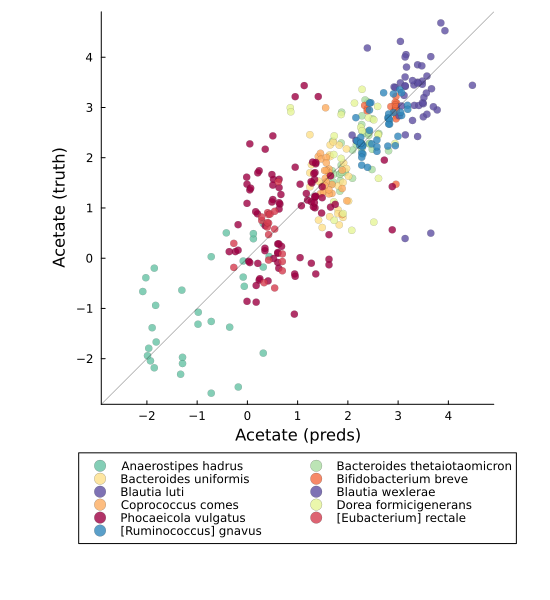

In [104]:
r = 5
predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked) |>
    df -> filter(:resample => ==(r), df)
@df predsdf scatter(
    :preds, :truth,
    group=trnYdf.species[:row_id],
    c=speciescolors_ordered,
    lims=extrema(vcat(:preds, :truth)),
    widen=true,
    ratio=1,
    size=(550,600),
    legend=:outerbottom,
    legend_column=2,
    markerstrokewidth=.1,
    alpha=.8,
    xlabel="$metabolite_name (preds)",
    ylabel="$metabolite_name (truth)",
)
plot!(identity, -20, 20, c=:black, alpha=.5, lw=0.5)

## Lasso model predictions

In [105]:
truth_oof_stacked = stack(lasso_oof_preds_df, r".*_true") |>
    df->select(df, 
        :row_id, 
        :variable => ((x)-> String.(first.(split.(x, "_")))) => :metabolite_name,
        :fold, 
        :value => :truth
    ) |>
    df -> filter(:metabolite_name => m-> m.∈Ref(orderedmetabolites_names), df);

fulllasso_oofpreds_stacked = stack(lasso_oof_preds_df, r".*pred_full") |>
    df->select(df, 
        :row_id, 
        :variable => ((x)-> String.(first.(split.(x, "_")))) => :metabolite_name,
        :fold, 
        :value => :pred_full
    ) |>
    df -> filter(:metabolite_name => m-> m.∈Ref(orderedmetabolites_names), df);

top10_oofpreds_stacked = stack(lasso_oof_preds_df, r".*pred_top10") |>
    df->select(df, 
        :row_id, 
        :variable => ((x)-> String.(first.(split.(x, "_")))) => :metabolite_name,
        :fold, 
        :value => :pred_top10
    ) |>
    df -> filter(:metabolite_name => m-> m.∈Ref(orderedmetabolites_names), df);

top3_oofpreds_stacked = stack(lasso_oof_preds_df, r".*pred_top3") |>
    df->select(df, 
        :row_id, 
        :variable => ((x)-> String.(first.(split.(x, "_")))) => :metabolite_name,
        :fold, 
        :value => :pred_top3
    ) |>
    df -> filter(:metabolite_name => m-> m.∈Ref(orderedmetabolites_names), df);

In [106]:
lasso_oof_preds_df_stacked = truth_oof_stacked
for preddf in [fulllasso_oofpreds_stacked, top10_oofpreds_stacked, top3_oofpreds_stacked]
    lasso_oof_preds_df_stacked = leftjoin(lasso_oof_preds_df_stacked, preddf, on=[:row_id, :metabolite_name], makeunique=true)
end

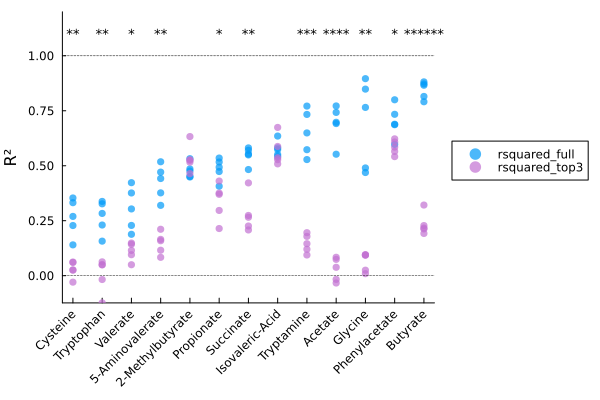

In [107]:
pltdf = lasso_oof_preds_df_stacked |>
    df -> filter(:metabolite_name => ∈(improvedmetabolite_names), df) |>
    df -> groupby(df, [:metabolite_name, :fold]) |>
    df -> combine(df,
    [:pred_full, :truth] => ((yhat, y)->rsquared(yhat,y)) => :rsquared_full, 
    [:pred_top3, :truth] => ((yhat, y)->rsquared(yhat,y)) => :rsquared_top3, 
    ) |>
    df -> groupby(df, [:metabolite_name]) |>
    df -> DataFrames.transform(df, 
        :rsquared_full => mean, 
        :rsquared_top3 => mean, 
    ) |>
    df -> stack(df, 3:4) |>
    df -> sort(df, :rsquared_full_mean)

sigresults = pltdf |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df,
        :rsquared_full_mean => first => :rsquared_full_mean,
        [:variable, :value] => ((grp, rsqval) -> 
            pvalue(UnequalVarianceTTest(rsqval[grp.=="rsquared_full"], rsqval[grp.=="rsquared_top3"]))) => :pval
    ) |>
    df -> DataFrames.transform(df, :pval => (p->adjust(p, BenjaminiHochberg())) => :pval_bh) |>
    df -> DataFrames.transform(df, :pval_bh => (p->floor.(Int, log10.(1 ./ p))) => :poweroftest)

plot(
    ylabel="R²",
    bottommargin=7Plots.Measures.mm,
    xrotation=45,
    legend=:outerright)
@df pltdf dotplot!(
    string.(round.(:rsquared_full_mean, digits=6)), :value,
    group=:variable,
    mode=:none,
    side=[:left :right],
    alpha=.7,
    markerstrokewidth=0,
    xticks=((1:length(unique(:metabolite_name))).-.5, unique(:metabolite_name)),
    ylims=(-Inf, 1.2),
    # label="Full lasso",
    c=[1 4],
)
hline!([0,1], c=:black, lw=.5, linestyle=:dash, legend=:outerright)
@df sigresults annotate!(
    string.(round.(:rsquared_full_mean, digits=6)), 
    ones(nrow(sigresults)) .+ 0.1,
    text.(
        repeat.("*", :poweroftest),
        9, :center,
    )
)

In [108]:
savefig(joinpath(pdir, "improvedmetabolites_full-vs-top3_dotplot.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model_mark2/improvedmetabolites_full-vs-top3_dotplot.pdf"

In [109]:
sbalassopltdf = oof_preds_df_stacked |> #filter(:resample => ==(1), oof_preds_df_stacked) |>
    df -> rename(df, :preds => :preds_SBA) |>
    df -> select(df, [:row_id, :metabolite_name, :fold, :resample, :truth, :preds_SBA]) |>
    df -> filter(:metabolite_name => ∈(improvedmetabolite_names), df) |>
    df -> groupby(df, [:metabolite_name, :fold, :resample]) |>
    df -> combine(df,
        [:preds_SBA, :truth] => ((yhat, y)->rsquared(yhat,y)) => :rsquared_SBA, 
    ) |>
    df -> groupby(df, [:metabolite_name]) |>
    df -> DataFrames.transform(df, 
        :rsquared_SBA => mean,
        [:fold, :resample] => ((x, y) -> x.*y) => :fold_iter,
    ) |>
    df -> stack(df, :rsquared_SBA) 

top3lassopltdf = lasso_oof_preds_df_stacked |>
    df -> filter(:metabolite_name => ∈(improvedmetabolite_names), df) |>
    df -> groupby(df, [:metabolite_name, :fold]) |>
    df -> combine(df,
    [:pred_top3, :truth] => ((yhat, y)->rsquared(yhat,y)) => :rsquared_top3, 
    ) |>
    df -> stack(df, :rsquared_top3)
top3lassopltdf[!,:rsquared_SBA_mean] .= sbalassopltdf.rsquared_SBA_mean[indexin(top3lassopltdf.metabolite_name, sbalassopltdf.metabolite_name)]

pltdf = vcat(select(sbalassopltdf, [:metabolite_name, :rsquared_SBA_mean, :variable, :value]),
    select(top3lassopltdf, [:metabolite_name, :rsquared_SBA_mean, :variable, :value])) |>
    df -> sort(df, :rsquared_SBA_mean)

sigresults = pltdf |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df,
        :rsquared_SBA_mean => first => :rsquared_SBA_mean,
        [:variable, :value] => ((grp, rsqval) -> 
            pvalue(UnequalVarianceTTest(rsqval[grp.=="rsquared_SBA"], rsqval[grp.=="rsquared_top3"]))) => :pval
    ) |>
    df -> DataFrames.transform(df, :pval => (p->adjust(p, BenjaminiHochberg())) => :pval_bh) |>
    df -> DataFrames.transform(df, :pval_bh => (p->floor.(Int, log10.(1 ./ p))) => :poweroftest);

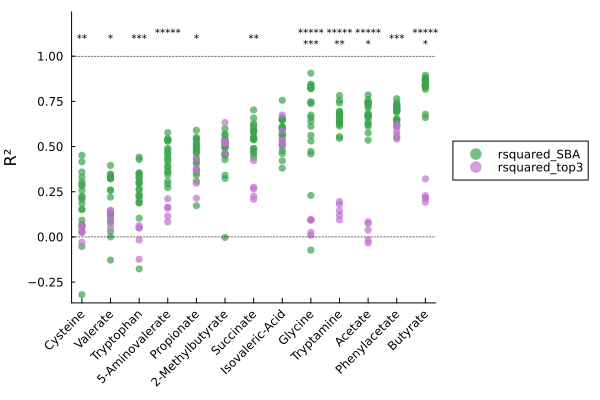

In [116]:
plot(
    ylabel="R²",
    bottommargin=7Plots.Measures.mm,
    xrotation=45,
    legend=:outerright)
@df pltdf dotplot!(
    string.(round.(:rsquared_SBA_mean, digits=6)), :value,
    group=:variable,
    mode=:none,
    side=[:left :right],
    alpha=.7,
    markerstrokewidth=0,
    xticks=((1:length(unique(:metabolite_name))).-.5, unique(:metabolite_name)),
    ylims=(-Inf, 1.2),
    widen=true,
    # label="Full lasso",
    c=[3 4],
)
hline!([0,1], c=:black, lw=.5, linestyle=:dash, legend=:outerright)
@df sigresults annotate!(
    string.(round.(:rsquared_SBA_mean, digits=6)), 
    ones(nrow(sigresults)) .+ 0.1,
    text.(
        replace.(repeat.("*", :poweroftest), r"(.{5})"=>s"\1\n"),
        # "1e-" .* string.(:poweroftest),
        7, :center,
    )
)

In [111]:
savefig(joinpath(pdir, "improvedmetabolites_sba-vs-top3_dotplot.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model_mark2/improvedmetabolites_sba-vs-top3_dotplot.pdf"

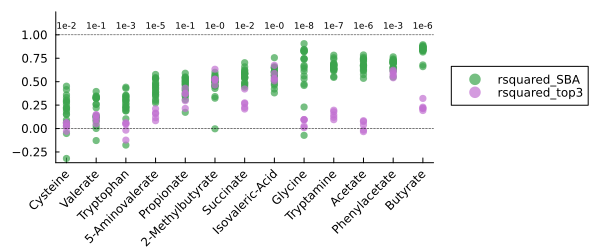

In [121]:
plot(
    # ylabel="R²",
    bottommargin=10Plots.Measures.mm,
    xrotation=45,
    legend=:outerright)
@df pltdf dotplot!(
    string.(round.(:rsquared_SBA_mean, digits=6)), :value,
    group=:variable,
    mode=:none,
    side=[:left :right],
    alpha=.7,
    markerstrokewidth=0,
    xticks=((1:length(unique(:metabolite_name))).-.5, unique(:metabolite_name)),
    ylims=(-Inf, 1.2),
    widen=true,
    size=(600, 250),
    # label="Full lasso",
    c=[3 4],
)
hline!([0,1], c=:black, lw=.5, linestyle=:dash, legend=:outerright)
@df sigresults annotate!(
    string.(round.(:rsquared_SBA_mean, digits=6)), 
    ones(nrow(sigresults)) .+ 0.1,
    text.(
        # replace.(repeat.("*", :poweroftest), r"(.{5})"=>s"\1\n"),
        "1e-" .* string.(:poweroftest),
        6, :center,
    )
)

In [122]:
savefig(joinpath(pdir, "improvedmetabolites_sba-vs-top3_dotplot_sigorder.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model_mark2/improvedmetabolites_sba-vs-top3_dotplot_sigorder.pdf"

In [143]:
bbobs_trn[treeorder[[1,2, 354, 355,356]], :]
# bbobs_trn[treeorder, :]

5×11 DataFrame
 Row │ ID         unique_id                        phylum         class        ⋯
     │ String     String                           String         String       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ DFI.1.247  DFI.1.247 Bacteroides uniformis  Bacteroidetes  Bacteroidia  ⋯
   2 │ DFI.1.135  DFI.1.135 Bacteroides uniformis  Bacteroidetes  Bacteroidia
   3 │ MSK.15.40  MSK.15.40 Anaerostipes hadrus    Firmicutes     Clostridia
   4 │ MSK.18.5   MSK.18.5 Blautia luti            Firmicutes     Clostridia
   5 │ MSK.14.58  MSK.14.58 Blautia glucerasea     Firmicutes     Clostridia   ⋯
                                                               7 columns omitted

In [144]:
biobank["metabolites_foldchange"].X[:,:][full_train_mask, 1][treeorder[[1,2, 354,355,356]]] |>
    x-> round.(x, digits=3)

5-element Vector{Float64}:
  1.861
  1.346
 -1.89
  2.45
  2.348

In [160]:
oof_preds_SLE_lassos = leftjoin(filter(:resample => ==(4), oof_preds_df_stacked), fulllasso_oofpreds_stacked,
        on = [:metabolite_name, :row_id], makeunique=true,) |>
    df -> leftjoin(df, top3_oofpreds_stacked, on = [:metabolite_name, :row_id], makeunique=true,) |>
    df -> select(df,
        :row_id,
        :metabolite_name,
        :truth,
        :preds => :preds_SLE,
        :pred_full => :preds_full,
        :pred_top3 => :preds_top3,
    );

In [ ]:
r = 5
predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked) |>
    df -> filter(:resample => ==(r), df)
@df predsdf scatter(
    :preds, :truth,
    group=trnYdf.species[:row_id],
    c=speciescolors_ordered,
    lims=extrema(vcat(:preds, :truth)),
    widen=true,
    ratio=1,
    size=(550,600),
    legend=:outerbottom,
    legend_column=2,
    markerstrokewidth=.1,
    alpha=.8,
    xlabel="$metabolite_name (preds)",
    ylabel="$metabolite_name (truth)",
)
plot!(identity, -20, 20, c=:black, alpha=.5, lw=0.5)

In [187]:
sorted_improvedmetabolite_names = [
    "Butyrate",
    "Phenylacetate",
    "Acetate",
    "Tryptamine",
    "Glycine",
    "Isovaleric-Acid",
    "Succinate",
    "2-Methylbutyrate",
    "Propionate",
    "5-Aminovalerate",
    "Tryptophan",
    "Valerate",
    "Cysteine",
]

13-element Vector{String}:
 "Butyrate"
 "Phenylacetate"
 "Acetate"
 "Tryptamine"
 "Glycine"
 "Isovaleric-Acid"
 "Succinate"
 "2-Methylbutyrate"
 "Propionate"
 "5-Aminovalerate"
 "Tryptophan"
 "Valerate"
 "Cysteine"

In [205]:
ps = []
for mname in sorted_improvedmetabolite_names
    pltdf = filter(:metabolite_name => ==(mname), oof_preds_SLE_lassos)
    p = plot(identity, -20, 20, c=:black, alpha=.5, lw=0.5)
    p = @df pltdf scatter!(:preds_SLE, :preds_full,
        group=trnYdf.species[:row_id],
        c=speciescolors_ordered,
        lims=extrema(vcat(:preds_SLE, :preds_full)),
        widen=true,
        ratio=1, legend=:none,
        markerstrokewidth=.1,
        alpha=.5,
        xrotation=45,
        title=mname,
        # xlabel="$mname (SLE)",
        # ylabel="$mname (full)",
        tickdirection=:none,
        framestyle=:box,
    )
    push!(ps, p)
end

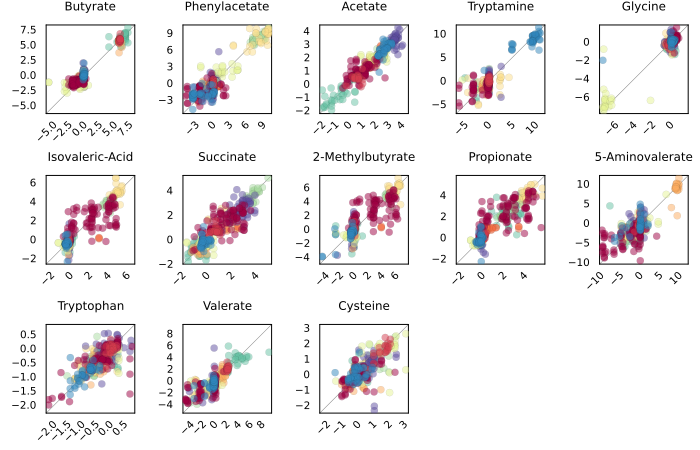

In [218]:
plot(ps..., layout=grid(3,5), titlefontsize=8, labelfontsize=6, tickfontsize=7, size=(700,450))

In [219]:
savefig(joinpath(pdir, "improvedmetabolites_SLEpreds-vs-FullPreds.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model_mark2/improvedmetabolites_SLEpreds-vs-FullPreds.pdf"

In [238]:
treeorder = indexin(getleafnames(subsettree), bbobs_trn.ID);

In [287]:
hadrusnames = bbobs_trn.ID[findall(contains.(bbobs_trn.species, "hadrus"))]
hadrus_treeidxs = indexin(hadrusnames, getleafnames(subsettree));
hadrustree = readnw(NewickTree.nwstr(NewickTree.extract(subsettree, hadrusnames)))
hadrusnames = getleafnames(hadrustree)
hadrus_treeidxs = indexin(hadrusnames, getleafnames(subsettree));

In [288]:
pltdf = filter(:metabolite_name => ==("Acetate"), oof_preds_SLE_lassos) |>
    df -> sort(df, :row_id);

In [289]:
hadruspltdf = pltdf[treeorder, :][hadrus_treeidxs,:]

31×6 DataFrame
 Row │ row_id  metabolite_name  truth       preds_SLE    preds_full  preds_top ⋯
     │ Int64   String31         Float64     Float64      Float64?    Float64?  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     69  Acetate          -0.0560327  -0.333483     -0.599118     2.3025 ⋯
   2 │     68  Acetate          -0.376019   -0.618599     -0.300093     2.2309
   3 │     70  Acetate          -0.560045   -0.618599     -0.149325     2.2385
   4 │    348  Acetate           0.504576   -0.618599     -0.693125     2.2675
   5 │    344  Acetate          -0.388559   -2.04722      -0.460805     2.2156 ⋯
   6 │    207  Acetate          -2.56377    -0.171042     -0.732079     2.2977
   7 │     67  Acetate          -0.177489    0.437046     -0.615918     2.2316
   8 │    157  Acetate           0.489918    0.401936      0.325342     2.2444
   9 │    312  Acetate           0.387263    0.00305167    0.238725     2.3184 ⋯
  10 │     51  Acetate           0.69065     0.00305167    0.186851     2.2187
  11 │    347  Acetate           0.0333048   0.401936     -1.37672      2.2606
  ⋮  │   ⋮            ⋮             ⋮            ⋮           ⋮           ⋮     ⋱
  22 │    144  Acetate          -0.198571   -1.37916      -1.20717      2.2431
  23 │    139  Acetate           0.0298967  -0.710359     -1.18125      2.2352 ⋯
  24 │    314  Acetate          -1.37304    -0.481873     -0.847198     2.2343
  25 │    315  Acetate          -2.30989    -0.50345      -1.17475      2.2202
  26 │    316  Acetate          -1.66784    -1.34952      -1.66751      2.2603
  27 │    129  Acetate          -0.663013   -1.1982       -0.849262     2.2805 ⋯
  28 │    318  Acetate          -0.636094   -1.30056      -1.27373      2.2228
  29 │    317  Acetate          -1.07547    -1.11272      -1.22924      2.2576
  30 │    313  Acetate          -1.3139     -0.850244     -0.947101     2.2591
  31 │    320  Acetate          -1.88973     0.401936     -0.575872     2.2125 ⋯
                                                    1 column and 10 rows omitted

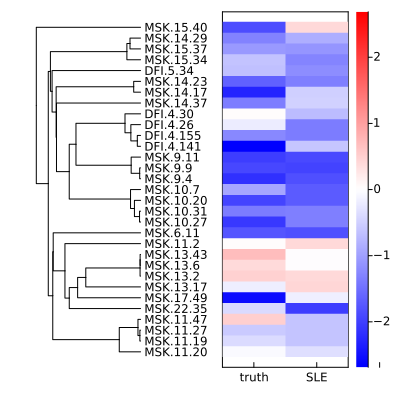

In [296]:
pltmtx = Matrix(hadruspltdf[:, [:truth, :preds_SLE]])
clims = getlims(pltmtx)
hp = heatmap(pltmtx,
    c=:bwr, clims=clims,
    xticks=(1:3, ["truth", "SLE"]),
    yticks=false,
    framestyle=:box
)
tp = plot(hadrustree, fs=8, rightmargin=15Plots.Measures.mm)
layout = @layout [a{.4w} b]
plot(tp, hp, layout=layout, link=:y, size=(400,400))

In [297]:
savefig(joinpath(pdir, "Ahadrus_Acetate_treeandpredictions.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model_mark2/Ahadrus_Acetate_treeandpredictions.pdf"

┌ Error: Error watching manifest
│   exception =
│    SystemError: opening file "/Users/ben/.julia/packages/DrWatson/Z2L2r/src/DrWatson.jl__@require__": No such file or directory
│    Stacktrace:
│     [1] systemerror(p::String, errno::Int32; extrainfo::Nothing)
│       @ Base ./error.jl:176
│     [2] #systemerror#80
│       @ ./error.jl:175 [inlined]
│     [3] systemerror
│       @ ./error.jl:175 [inlined]
│     [4] open(fname::String; lock::Bool, read::Nothing, write::Nothing, create::Nothing, truncate::Nothing, append::Nothing)
│       @ Base ./iostream.jl:293
│     [5] open
│       @ ./iostream.jl:275 [inlined]
│     [6] open(f::Base.var"#387#388"{String}, args::String; kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
│       @ Base ./io.jl:382
│     [7] open
│       @ ./io.jl:381 [inlined]
│     [8] read
│       @ ./io.jl:462 [inlined]
│     [9] (::Revise.var"#43#44"{String})()
│       @ Revise ~/.julia/packages/Revise/Kw99o/src/pkgs.jl:450
└ @ Revise ~/.juli